## 1. 定义算法

NoisyDQN 是在 DQN 的基础上进行改进，主要就是通过在训练网络的时候加上一些噪声参数，可以用较小的额外计算成本，在强化学习算法上获得更优的结果。
配置和 DQN 基本一致，只是在模型定义的时候，在模型中加入了一些噪声参数。

### 1.1、 定义模型
这里使用了一个三层的MLP，不同的是其中加入了一些噪声参数，就是每个权值weight和偏置bias中都有额外的参数mu和sigma，这里仅供参考。

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
class NoisyLinear(nn.Module):
    def __init__(self, input_dim, output_dim, std_init=0.4):
        super(NoisyLinear, self).__init__()
        
        self.input_dim  = input_dim
        self.output_dim = output_dim
        self.std_init     = std_init
        
        self.weight_mu    = nn.Parameter(torch.FloatTensor(output_dim, input_dim))
        self.weight_sigma = nn.Parameter(torch.FloatTensor(output_dim, input_dim))
        self.register_buffer('weight_epsilon', torch.FloatTensor(output_dim, input_dim))
        
        self.bias_mu    = nn.Parameter(torch.FloatTensor(output_dim))
        self.bias_sigma = nn.Parameter(torch.FloatTensor(output_dim))
        self.register_buffer('bias_epsilon', torch.FloatTensor(output_dim))
        
        self.reset_parameters()
        self.reset_noise()
    
    def forward(self, x):
        if self.training: 
            weight = self.weight_mu + self.weight_sigma.mul(torch.tensor(self.weight_epsilon))
            bias   = self.bias_mu   + self.bias_sigma.mul(torch.tensor(self.bias_epsilon))
        else:
            weight = self.weight_mu
            bias   = self.bias_mu
        
        return F.linear(x, weight, bias)
    
    def reset_parameters(self):
        mu_range = 1 / math.sqrt(self.weight_mu.size(1))
        
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.weight_sigma.size(1)))
        
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.bias_sigma.size(0)))
    
    def reset_noise(self):
        epsilon_in  = self._scale_noise(self.input_dim)
        epsilon_out = self._scale_noise(self.output_dim)
        
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(self._scale_noise(self.output_dim))
    
    def _scale_noise(self, size):
        x = torch.randn(size)
        x = x.sign().mul(x.abs().sqrt())
        return x

class NoisyMLP(nn.Module):
    def __init__(self, input_dim,output_dim,hidden_dim=128):
        super(NoisyMLP, self).__init__()
        self.fc1 =  nn.Linear(input_dim, hidden_dim)
        self.noisy_fc2 = NoisyLinear(hidden_dim, hidden_dim)
        self.noisy_fc3 = NoisyLinear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.noisy_fc2(x))
        x = self.noisy_fc3(x)
        return x

    def reset_noise(self):
        self.noisy_fc2.reset_noise()
        self.noisy_fc3.reset_noise()


### 1.2、定义经验回放

这里的经验回放和DQN中保持一致，也是具有一定容量，只有存储到一定的transition网络才会更新。经验回放的时候一般包涵两个功能或方法，一个是push，即将一个transition样本按顺序放到经验回放中，如果满了就把最开始放进去的样本挤掉；另外一个是sample，就是随机采样出一个或者若干个（具体多少就是batch_size了）样本供DQN网络更新。

In [2]:
from collections import deque
import random
class ReplayBuffer(object):
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    def push(self,transitions):
        ''' 存储transition到经验回放中
        '''
        self.buffer.append(transitions)
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer): # 如果批量大小大于经验回放的容量，则取经验回放的容量
            batch_size = len(self.buffer)
        if sequential: # 顺序采样
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else: # 随机采样
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def clear(self):
        ''' 清空经验回放
        '''
        self.buffer.clear()
    def __len__(self):
        ''' 返回当前存储的量
        '''
        return len(self.buffer)

### 1.3、模型算法定义

这里根据前面的噪声MLP搭建智能体agent，其中的动作采样和模型更新和DQN基本一致，这里不再赘述。

In [3]:
import torch
import torch.optim as optim
import math
import numpy as np

class NoisyDQN:
    def __init__(self, model, memory, cfg) -> None:
        self.n_actions = cfg.n_actions  
        self.device = torch.device(cfg.device) 
        self.gamma = cfg.gamma  
        ## e-greedy策略相关参数
        self.sample_count = 0  # 用于epsilon的衰减计数
        self.epsilon = cfg.epsilon_start
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.batch_size = cfg.batch_size
        self.target_update = cfg.target_update

        self.device = torch.device(cfg.device) 

        self.policy_net = model.to(self.device)
        self.target_net = model.to(self.device)
        ## 复制参数到目标网络
        for target_param, param in zip(self.target_net.parameters(),self.policy_net.parameters()): 
            target_param.data.copy_(param.data)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg.lr)
        self.memory = memory ## 经验回放
        self.update_flag = False
        
    def sample_action(self, state):
        ''' sample action with e-greedy policy 
        '''
        self.sample_count += 1
        # epsilon 指数衰减
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) 
        if random.random() > self.epsilon:
            with torch.no_grad():
                state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
                q_values = self.policy_net(state)
                action = q_values.max(1)[1].item() # 根据Q值选择动作
        else:
            action = random.randrange(self.n_actions)
        return action

    @torch.no_grad()
    def predict_action(self, state):
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        q_value = self.policy_net(state)
        action  = q_value.max(1)[1].item()
        return action
    def update(self):
        if len(self.memory) < self.batch_size: # 不满足一个批量时，不更新策略
            return
        else:
            if not self.update_flag:
                print("Begin to update!")
                self.update_flag = True
        # beta = min(1.0, self.beta_start + self.sample_count * (1.0 - self.beta_start) / self.beta_frames)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(
            self.batch_size)
        # state_batch, action_batch, reward_batch, next_state_batch, done_batch, weights_batch, indices = self.memory.sample(self.batch_size, beta) 
        state_batch = torch.tensor(np.array(state_batch), device=self.device, dtype=torch.float) 
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(1)
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float).unsqueeze(1)
        next_state_batch = torch.tensor(np.array(next_state_batch), device=self.device, dtype=torch.float) # shape(batchsize,n_states)
        done_batch = torch.tensor(done_batch, device=self.device, dtype=torch.float).unsqueeze(1)
        # weights_batch = torch.tensor(weights_batch, device=self.device, dtype=torch.float)

        q_value_batch = self.policy_net(state_batch).gather(dim=1, index=action_batch) # shape(batchsize,1),requires_grad=True
        next_max_q_value_batch = self.target_net(next_state_batch).max(1)[0].detach().unsqueeze(1) 
        expected_q_value_batch = reward_batch + self.gamma * next_max_q_value_batch* (1-done_batch)

        loss = nn.MSELoss()(q_value_batch, expected_q_value_batch)  # shape same to  
        # 反向传播
        self.optimizer.zero_grad()  
        loss.backward()
        # 梯度截断，防止梯度爆炸
        for param in self.policy_net.parameters():  
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step() 

        if self.sample_count % self.target_update == 0: # 更新 target_net
            self.target_net.load_state_dict(self.policy_net.state_dict())   

        ## 噪声参数重置
        self.policy_net.reset_noise()
        self.target_net.reset_noise()

## 2、 定义训练

In [4]:
def train(cfg, env, agent):
    ''' 训练
    '''
    print("开始训练！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state = env.reset()  # 重置环境，返回初始状态
        for _ in range(cfg.max_steps):
            ep_step += 1
            action = agent.sample_action(state)  # 选择动作
            next_state, reward, done, _ = env.step(action)  # 更新环境，返回transition
            agent.memory.push((state, action, reward,next_state, done))  # 保存transition
            state = next_state  # 更新下一个状态
            agent.update()  # 更新智能体
            ep_reward += reward  # 累加奖励
            if done:
                break
        if (i_ep + 1) % cfg.target_update == 0:  # 智能体目标网络更新
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        steps.append(ep_step)
        rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}，Epislon：{agent.epsilon:.3f}")
    print("完成训练！")
    env.close()
    return {'rewards':rewards}

def test(cfg, env, agent):
    print("开始测试！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state = env.reset()  # 重置环境，返回初始状态
        for _ in range(cfg.max_steps):
            ep_step+=1
            action = agent.predict_action(state)  # 选择动作
            next_state, reward, done, _ = env.step(action)  # 更新环境，返回transition
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if done:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.2f}")
    print("完成测试")
    env.close()
    return {'rewards':rewards}

## 3. 定义环境

In [5]:
import gym
import os
def all_seed(env,seed = 1):
    ''' 万能的seed函数
    '''
    env.seed(seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = gym.make(cfg.env_name) # 创建环境
    if cfg.seed !=0:
        all_seed(env,seed=cfg.seed)
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.n
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}")

    cfg.n_actions = env.action_space.n  ## set the env action space
    model = NoisyMLP(n_states, n_actions, hidden_dim = cfg.hidden_dim) # 创建模型
    memory = ReplayBuffer(cfg.buffer_size)
    agent = NoisyDQN(model,memory,cfg)
    return env,agent

## 4、设置参数

In [6]:
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
class Config():
    def __init__(self) -> None:
        self.env_name = "CartPole-v1" # 环境名字
        self.new_step_api = True # 是否用gym的新api
        self.wrapper = None 
        self.render = False 
        self.algo_name = "NoisyDQN" # 算法名字
        self.mode = "train" # train or test
        self.seed = 0 # 随机种子
        self.device = "cpu" # device to use
        self.train_eps = 100 # 训练的回合数
        self.test_eps = 20 # 测试的回合数
        self.eval_eps = 10 # 评估的回合数
        self.eval_per_episode = 5 # 每个回合的评估次数
        self.max_steps = 200 # 每个回合的最大步数
        self.load_checkpoint = False
        self.load_path = "tasks" # 加载模型的路径
        self.show_fig = False # 是否展示图片
        self.save_fig = True # 是否存储图片


        # 设置epsilon值
        self.epsilon_start = 0.95 # 起始的epsilon值
        self.epsilon_end = 0.01 # 终止的epsilon值
        self.epsilon_decay = 500 # 衰减率
        self.hidden_dim = 256 
        self.gamma = 0.95 
        self.lr = 0.0001 
        self.buffer_size = 100000 # 经验回放的buffer大小
        self.batch_size = 64 # batch size
        self.target_update = 4 # 目标网络更新频率
        self.value_layers = [
            {'layer_type': 'linear', 'layer_dim': ['n_states', 256],
             'activation': 'relu'},
            {'layer_type': 'linear', 'layer_dim': [256, 256],
             'activation': 'relu'},
            {'layer_type': 'linear', 'layer_dim': [256, 'n_actions'],
             'activation': 'none'}]

def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,cfg, tag='train'):
    ''' 画图
    '''
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()
    plt.show()


## 5、开始训练

E:\python\miniconda3\envs\rl\lib\site-packages\gym\core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
E:\python\miniconda3\envs\rl\lib\site-packages\gym\wrappers\step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
E:\python\miniconda3\envs\

状态空间维度：4，动作空间维度：2
开始训练！
Begin to update!
回合：10/100，奖励：26.00，Epislon：0.628
回合：20/100，奖励：12.00，Epislon：0.501
回合：30/100，奖励：48.00，Epislon：0.330
回合：40/100，奖励：17.00，Epislon：0.230
回合：50/100，奖励：32.00，Epislon：0.109
回合：60/100，奖励：34.00，Epislon：0.046
回合：70/100，奖励：69.00，Epislon：0.021
回合：80/100，奖励：200.00，Epislon：0.010
回合：90/100，奖励：200.00，Epislon：0.010
回合：100/100，奖励：200.00，Epislon：0.010
完成训练！


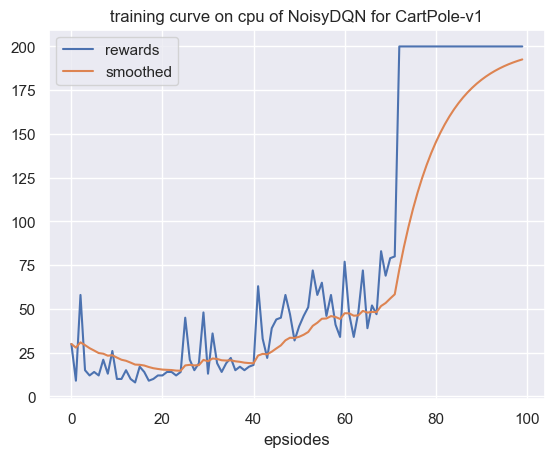

开始测试！
回合：1/20，奖励：200.00
回合：2/20，奖励：200.00
回合：3/20，奖励：200.00
回合：4/20，奖励：200.00
回合：5/20，奖励：200.00
回合：6/20，奖励：200.00
回合：7/20，奖励：200.00
回合：8/20，奖励：200.00
回合：9/20，奖励：200.00
回合：10/20，奖励：200.00
回合：11/20，奖励：200.00
回合：12/20，奖励：200.00
回合：13/20，奖励：200.00
回合：14/20，奖励：200.00
回合：15/20，奖励：200.00
回合：16/20，奖励：200.00
回合：17/20，奖励：200.00
回合：18/20，奖励：200.00
回合：19/20，奖励：200.00
回合：20/20，奖励：200.00
完成测试


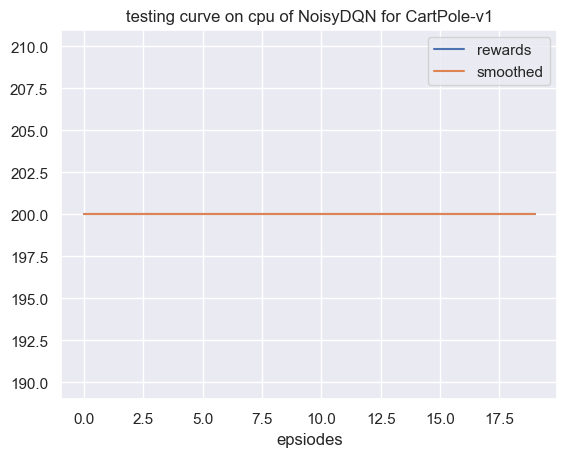

In [7]:
# 获取参数
cfg = Config() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], cfg, tag="train")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], cfg, tag="test")  # 画出结果